1. SVM Classifier
    - Calculating loss and gradient
2. Linear Classfier with Softmax 
    - Calculating loss and gradient
3. Simple Neural Network with Multilayer Perceptrons
    - Read the forward and backward propogation
    - Experiment with simple NN

This is inspired and adopted from Stanford CS231n, UIUC Deep Learning course and Deep Learning Lab from Professor Vicente Ordonez at the University of Virginia.









You would need to use **Python 3.6+** along with the following packages:
```
1. numupy
2. matplotlib
3. scipy
```
All packages above can be installed through `pip install`.

In addition, you will need to have [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset in your `cifar10/cifar-10-batches-py` folder. We provide a bash script `cifar10/get_dataset.sh` to help you download and unpack the dataset.

Once you are done with the things above, you can proceed to execute the following cells:


# Section 0. Environment Set Up

In [ ]:
# print base directory
!pwd

/content


In [ ]:
import torch

In [ ]:
# Check whether GPU is available
torch.cuda.is_available()

True

In [ ]:
# Check the name of the GPU
torch.cuda.get_device_name()

'Tesla V100-SXM2-16GB'

In [ ]:
# Check GPU id
torch.cuda.current_device()

0

In [ ]:
# Set device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import random
import numpy as np
from data_process import get_CIFAR10_data
import math
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#changing directory to cifar10
%cd cifar10

/content/cifar10


In [ ]:
!/content/cifar10/get_datasets.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  21.1M      0  0:00:07  0:00:07 --:--:-- 28.9M
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


# Loading CIFAR-10

In the following cells, we would first load the CIFAR10 dataset, and prepare them for our classifier:

In [ ]:
# reverting back to thr base directory
%cd /content

/content


In [ ]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 49000
VAL_IMAGES = 1000
TEST_IMAGES = 1000

In [ ]:
data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES, subtract_mean=False)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

In [ ]:
print(f"X_train_shape:{X_train.shape}")
print(f"y_train_shape:{y_train.shape}")
print(f"X_val_shape:{X_val.shape}")
print(f"y_val_shape:{y_val.shape}")
print(f"X_test_shape:{X_test.shape}")
print(f"y_test_shape:{y_test.shape}")

X_train_shape:(49000, 32, 32, 3)
y_train_shape:(49000,)
X_val_shape:(1000, 32, 32, 3)
y_val_shape:(1000,)
X_test_shape:(1000, 32, 32, 3)
y_test_shape:(1000,)


Now, we visualize the dataset to get a better idea of it.

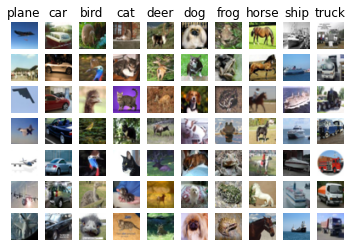

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

We then subtract all the images with the **mean image** of the training set. This trick is commonly used in Computer Vision community, as it arranges the features into a range that is more manageable for the models.

In [ ]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

Now, we convert the sets of images from dimensions of **(N, 3, 32, 32) -> (N, 3072)** where N is the number of images so that each **3x32x32** image is represented by a single vector. This allows us to feed the data into our classifiers.

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [ ]:
print(f"X_train_shape:{X_train.shape}")
print(f"X_val_shape:{X_val.shape}")
print(f"X_test_shape:{X_test.shape}")

X_train_shape:(49000, 3072)
X_val_shape:(1000, 3072)
X_test_shape:(1000, 3072)


Here, we concatenate all the features with ones. This trick is particularly convenient, as in this case, we only need to deal with a single weight matrix $W$ instead of both $W$ and bias $b$ in our training code.

In [ ]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

In [ ]:
# you should get the following output:
# (49000, 3073)
# (1000, 3073)
# (1000, 3073)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3073)
(1000, 3073)
(1000, 3073)


### Calculate Classification Accuracy

Here is a simple helper function for calculation the classification accuracy:

In [ ]:
def get_acc(pred, y_test):
    return np.sum(y_test==pred)/len(y_test)*100

In [ ]:
# test get_acc
print(get_acc(y_train, y_train))

100.0


# Section 1. Support Vector Machines (with SGD)

In this section, you will need to implement a **soft margin SVM** for a **multi-class classification problem**. In the soft margin SVM, you will maximize the margin between positive and negative training examples and penalize margin violations using a hinge loss.

We will optimize the SVM loss using SGD. This means you must compute the loss function with respect to model weights. You will use this gradient to update the model weights.

SVM optimized with SGD has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

## 1.1. Implementing SVM with SGD

Recall that the multiclass SVM loss can be written as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = \sum_{j\neq y_i} \left[ \max(0, s_j - s_{y_i} + margin) \right]
\end{gathered}
\end{align}
where $s={s_j}$ is the vector of prediction scores of all class, $s_j$ is the prediction score for class $j$, and $y_i$ is the groud truth class label. The margin is usually set to 1. Now, to learn the weights $W$, we can differentiate the function $L_i$ to get the gradient:
\begin{equation}
\begin{gathered}
\nabla_{w_{y_i}} L_i = - \left( \sum_{j\neq y_i} \mathbb{I}(w_j^Tx_i - w_{y_i}^Tx_i + margin > 0) \right) x_i\\
\end{gathered}
\end{equation}
where $\mathbb{I}$ is the indicator function that is one if the condition inside is true or zero otherwise, and $w_j$ represents the row $j$ in your weight matrix $W$. To implement this, you’d simply count the number of classes that didn’t meet the desired margin (and hence contributed to the loss function) and then the data vector $x_i$ scaled by this number is the gradient. Note that, in the equation above, we are only calculating the gradient with respect to the row of $W$ that corresponds to the correct class $y_i$. For the other rows $j\neq y_i$, we have:
\begin{equation}
\nabla_{w_j} L_i = \mathbb{I}(w_j^Tx_i - w_{y_i}^Tx_i + margin > 0) x_i
\end{equation}
Now, we have derived the gradient expression above, it is time to turn these equations into the actual running code.
We provide a template for implementing your SVM classfier below. You have to fill in the **TODO** part, and train your classifier.

In [ ]:
class SVM():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001 #weights
        #print(self.w.shape)
        
    def calc_grad_and_loss(self, X_train, y_train, reg, margin):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;
          - margin: A float number margin for the multi-class SVM loss (usually set to 1);

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
        """
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the SVM classifier.                      #
        ################################################################################
        #Loss     
        num_train = X_train.shape[0]   
        scores = np.dot(X_train, self.w)       
        y_correct_scores =  np.expand_dims(scores[np.arange(num_train),y_train], axis=1)
        loss_i = np.maximum(0, scores - y_correct_scores + margin)
        loss_i[np.arange(scores.shape[0]),y_train] = 0
        loss = np.mean(np.sum(loss_i, axis=1)) 
        loss += 0.5*reg*np.sum(self.w*self.w)   

        #Gradient
        mask = np.zeros(loss_i.shape)
        mask[loss_i > 0] = 1
        count = np.sum(mask,axis=1)
        mask[np.arange(num_train),y_train] = -count
        grad_w = np.dot(X_train.T, mask)
        grad_w /= num_train
        grad_w += reg*self.w       
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return grad_w, loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, margin=1.0, 
              n_iters=1500, batch_size=200):
        """
        Train SVM classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - margin: A float number margin for the multi-class SVM loss (usually set to 1);
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const, margin)
            self.w -= lr * grad
            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        pred = np.argmax(np.dot(X_test, self.w),axis=1)        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred
    


### Train your SVM
Now, train your SVM classifier. You should expect the loss decreases as the training goes on.

In [ ]:
n_iter = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
svm = SVM(num_features, num_classes)
loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=1500)

Iter 100/1500 - loss: 79.03677173104386 
Iter 200/1500 - loss: 71.0230321705143 
Iter 300/1500 - loss: 63.20491397962487 
Iter 400/1500 - loss: 58.1953762092337 
Iter 500/1500 - loss: 52.135930613172775 
Iter 600/1500 - loss: 48.24727285443192 
Iter 700/1500 - loss: 44.09079934856503 
Iter 800/1500 - loss: 39.02712868273249 
Iter 900/1500 - loss: 35.68173489664177 
Iter 1000/1500 - loss: 32.740372512140596 
Iter 1100/1500 - loss: 29.845115058359244 
Iter 1200/1500 - loss: 27.826991157383272 
Iter 1300/1500 - loss: 25.253236738439103 
Iter 1400/1500 - loss: 22.979234173239128 
Iter 1500/1500 - loss: 21.504768492657682 


### Plot the Loss Curve
Plotting the loss curve is a proper etiquette for Machine Learning/Deep Learning practitioner.

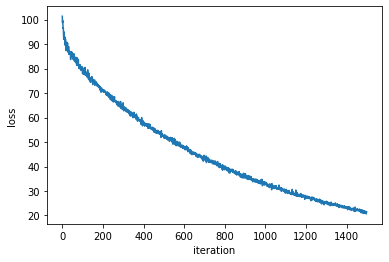

In [ ]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the SVM is implemented correctly, you shuold get an training/validation accuracy around 34%-35%.

In [ ]:
pred_svm = svm.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_svm, y_train)))
pred_svm = svm.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_svm, y_val)))

The training accuracy is given by : 34.132653
The validation accuracy is given by : 34.900000


## Section 1.2. Improve your SVM
Now, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.**

a) Increasing the number of iterations

In [ ]:
n_iter = 5500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
svm = SVM(num_features, num_classes)
loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=5500)

Iter 100/5500 - loss: 82.25343616426014 
Iter 200/5500 - loss: 72.91354298984567 
Iter 300/5500 - loss: 66.26495098324834 
Iter 400/5500 - loss: 58.33261106998825 
Iter 500/5500 - loss: 52.41449310223651 
Iter 600/5500 - loss: 48.254241007813 
Iter 700/5500 - loss: 44.37265958633934 
Iter 800/5500 - loss: 40.57961818927581 
Iter 900/5500 - loss: 36.68403139147191 
Iter 1000/5500 - loss: 33.8855279983543 
Iter 1100/5500 - loss: 29.967329253546907 
Iter 1200/5500 - loss: 28.35105679600425 
Iter 1300/5500 - loss: 25.786537739755918 
Iter 1400/5500 - loss: 23.72999403811794 
Iter 1500/5500 - loss: 21.986167934192842 
Iter 1600/5500 - loss: 20.119752680812304 
Iter 1700/5500 - loss: 18.18724612310509 
Iter 1800/5500 - loss: 16.857459229490296 
Iter 1900/5500 - loss: 16.239437354206853 
Iter 2000/5500 - loss: 15.088248428972788 
Iter 2100/5500 - loss: 13.992142269771303 
Iter 2200/5500 - loss: 12.879139485433654 
Iter 2300/5500 - loss: 12.084840758742907 
Iter 2400/5500 - loss: 11.9869005097

 Test SVM
Evaluate the testing accuracy of your SVM:

In [ ]:
pred_svm = svm.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_svm, y_test)))

The testing accuracy is given by : 38.900000


b) Grid Search

In [ ]:
learning_rates = [1e-8, 1e-7, 3e-7, 5e-7]
regularization = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4]
n_iter = 1500
batch_size = 100
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
best_validation_accuracy = -1
results ={}
for l in learning_rates:  
  for r in regularization:
    svm = SVM(num_features, num_classes)
    print(f"Hyperparameters- learning_rate: {l}, regularization: {r}")
    loss_hist = svm.train(X_train, y_train, lr=l, reg_const=r, n_iters=n_iter)

    pred_svm = svm.predict(X_train)
    print(f"The training accuracy is given by : {get_acc(pred_svm, y_train)}")

    pred_svm = svm.predict(X_val)
    validation_accuracy = get_acc(pred_svm, y_val)    
    print(f"The validation accuracy is given by : {validation_accuracy}")
    
    pred_svm = svm.predict(X_test)
    test_accuracy = get_acc(pred_svm, y_test)    
    print(f"The testing accuracy is given by : {test_accuracy}")

    results[(l, r)] = validation_accuracy

    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      best_svm = svm
    print(f"Best val accuracy:{best_validation_accuracy}")
    print("done\n")


Hyperparameters- learning_rate: 1e-08, regularization: 10000.0
Iter 100/1500 - loss: 168.04810695223813 
Iter 200/1500 - loss: 165.3024966087627 
Iter 300/1500 - loss: 159.29646263067667 
Iter 400/1500 - loss: 154.16429308466672 
Iter 500/1500 - loss: 149.99075796745103 
Iter 600/1500 - loss: 146.5088984811837 
Iter 700/1500 - loss: 144.3347413973288 
Iter 800/1500 - loss: 142.88438253358746 
Iter 900/1500 - loss: 138.16245347751246 
Iter 1000/1500 - loss: 135.9785413942311 
Iter 1100/1500 - loss: 134.2664016873195 
Iter 1200/1500 - loss: 128.995432851259 
Iter 1300/1500 - loss: 126.96800830125916 
Iter 1400/1500 - loss: 124.78382930989649 
Iter 1500/1500 - loss: 122.67732421166014 
The training accuracy is given by : 22.544897959183675
The validation accuracy is given by : 25.0
The testing accuracy is given by : 22.5
Best val accuracy:25.0
done

Hyperparameters- learning_rate: 1e-08, regularization: 20000.0
Iter 100/1500 - loss: 313.2021372675652 
Iter 200/1500 - loss: 299.36114886573

In [ ]:
print(f"Results: {results}")
pred_svm = best_svm.predict(X_test)
print('The best testing accuracy is given by : %f' % (get_acc(pred_svm, y_test)))

Results: {(1e-08, 10000.0): 25.0, (1e-08, 20000.0): 24.8, (1e-08, 30000.0): 24.3, (1e-08, 40000.0): 23.599999999999998, (1e-08, 50000.0): 27.6, (1e-08, 60000.0): 26.5, (1e-08, 70000.0): 26.3, (1e-08, 80000.0): 28.999999999999996, (1e-07, 10000.0): 38.800000000000004, (1e-07, 20000.0): 39.6, (1e-07, 30000.0): 38.3, (1e-07, 40000.0): 38.800000000000004, (1e-07, 50000.0): 38.6, (1e-07, 60000.0): 35.199999999999996, (1e-07, 70000.0): 38.0, (1e-07, 80000.0): 37.9, (3e-07, 10000.0): 37.3, (3e-07, 20000.0): 39.1, (3e-07, 30000.0): 36.6, (3e-07, 40000.0): 38.3, (3e-07, 50000.0): 36.1, (3e-07, 60000.0): 36.3, (3e-07, 70000.0): 35.8, (3e-07, 80000.0): 35.0, (5e-07, 10000.0): 34.599999999999994, (5e-07, 20000.0): 35.099999999999994, (5e-07, 30000.0): 35.0, (5e-07, 40000.0): 37.0, (5e-07, 50000.0): 32.9, (5e-07, 60000.0): 33.4, (5e-07, 70000.0): 35.3, (5e-07, 80000.0): 31.8}
The best testing accuracy is given by : 37.300000


### Visualization
Visualize the weights of your best model. 

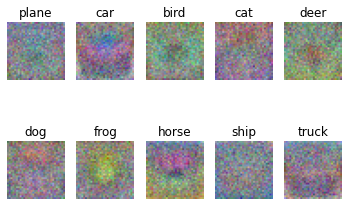

In [ ]:
# Visualize the learned weights for each class.
# Hint: reshape your weights (w/o bias) to (32, 32, 3, 10), then use min-max normalization and rescale them back to 0-255.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#print(best_svm.w.shape)
best_weights = best_svm.w[:-1, :]
best_weights = best_weights.reshape(32,32,3,10)
best_weights_min, best_weights_max = np.min(best_weights), np.max(best_weights)

# plot for each class
for i in range(len(classes)):
  plt.subplot(2, 5, i + 1) 
  img = 255.0 * (best_weights[:, :, :, i].squeeze() - best_weights_min) / (best_weights_max - best_weights_min)
  plt.imshow(img.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

Your comments: It appears that the weights are like a template and the SVM algorithm tries to best match the given input image with one of the templates. For example, the car template looks somewhat like a car. Also, if we look at the ship template, it seems that there is some object in the middle surrounded by blue color, which could imply water. 

# Section 2. Softmax Classifier (with SGD)

Next, you will train a Softmax classifier. This classifier consists of a linear function of the input data followed by a softmax function which outputs a vector of dimension C (number of classes) for each data point. Each entry of the softmax output vector corresponds to a confidence in one of the C classes, and like a probability distribution, the entries of the output vector sum to 1. 

## Section 2.1. Implement the Softmax Classifier
Recall that, from the lecture, we can write down the loss function as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = -\log\left({\frac{e^{s_{y_i}}} {\sum_j e^{s_j}} }\right)
\end{gathered}
\end{align}

And, through some calculations, we can obtain the expression for the gradient:
\begin{align}
\nabla_{w_{l}} L_i = \left(\frac{e^{w_l^Tx_i}} {\sum_j e^{w_j^Tx_i}} - \mathbb{I}\left(y_i=l\right)\right) x_i\\
\end{align}


The softmax classifier also has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

Same as the previous section, we provide a template for you to implement your classifier:

In [ ]:
 class Softmax_Classfier():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001
    
    def softmax(self, logits, esp=1e-7):
        ################################################################################
        # TODO:                                                                        #
        # Implement the softmax function here.                                         #
        ################################################################################
        scores = np.exp(logits)
        probs = scores / np.sum(scores, axis=1, keepdims=True)        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return probs
    
    def calc_grad_and_loss(self, X_train, y_train, reg_const):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
         """ 
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the SVM classifier.                      #
        ################################################################################
        # Loss
        num_train = X_train.shape[0]   
        scores = np.dot(X_train, self.w)       
        scores_softmax = self.softmax(scores)        
        loss = -np.log(scores_softmax)        
        loss = loss[np.arange(num_train), y_train]
        loss = np.sum(loss)
        loss /=num_train
        loss += 0.5*reg_const*np.sum(self.w*self.w) 
        #print(loss) 

        #Gradient
        temp = scores_softmax
        temp[np.arange(num_train),y_train] =-1
        grad_w = np.dot(X_train.T, temp)
        grad_w /=num_train
        grad_w += reg_const*self.w       
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return grad_w, loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, 
              n_iters=1500, batch_size=200):
        """
        Train softmax classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const)
            self.w -= lr * grad
            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        
        #pred = np.argmax(self.softmax(np.dot(X_test, self.w)),axis=1)  
        pred = np.argmax(self.softmax(np.dot(X_test, self.w)), axis =1)        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred


In [ ]:
n_iter = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
softmax_classifier = Softmax_Classfier(num_features, num_classes)
loss_hist = softmax_classifier.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=1500, batch_size=batch_size)

Iter 100/1500 - loss: 74.0236719170772 
Iter 200/1500 - loss: 66.76218628305622 
Iter 300/1500 - loss: 60.39372813379031 
Iter 400/1500 - loss: 54.810422399445244 
Iter 500/1500 - loss: 49.438247107959555 
Iter 600/1500 - loss: 44.85553863953817 
Iter 700/1500 - loss: 41.073111201364526 
Iter 800/1500 - loss: 36.93948839791927 
Iter 900/1500 - loss: 34.06224688172821 
Iter 1000/1500 - loss: 30.498682193492687 
Iter 1100/1500 - loss: 28.1398984456943 
Iter 1200/1500 - loss: 25.539610022179524 
Iter 1300/1500 - loss: 23.154986907993454 
Iter 1400/1500 - loss: 21.083382393566925 
Iter 1500/1500 - loss: 19.128983084838374 


Again, plot the loss:

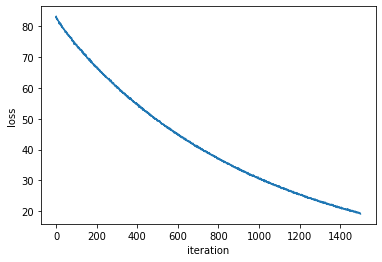

In [ ]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the Softmax Classifier is implemented correctly, you shuold get an accuracy around 29%.

In [ ]:
pred_softmax = softmax_classifier.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_softmax, y_train)))
pred_softmax = softmax_classifier.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_softmax, y_val)))

The training accuracy is given by : 32.304082
The validation accuracy is given by : 33.100000


## Section 2.1. Improve your Softmax Classifier
Again, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.** In addition, <span style="color:red">**We expect to see an accuracy around 34% after the improvement.**</span>


a) Increasing the number of iterations

In [ ]:
n_iter = 5500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
softmax_classifier = Softmax_Classfier(num_features, num_classes)
loss_hist = softmax_classifier.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=n_iter, batch_size=batch_size)

Iter 100/5500 - loss: 72.55323363908478 
Iter 200/5500 - loss: 65.71440472022846 
Iter 300/5500 - loss: 59.371341693743176 
Iter 400/5500 - loss: 54.15852501030462 
Iter 500/5500 - loss: 48.490939156083456 
Iter 600/5500 - loss: 43.878959837845755 
Iter 700/5500 - loss: 40.022353083947465 
Iter 800/5500 - loss: 36.634524682665685 
Iter 900/5500 - loss: 33.08180108594665 
Iter 1000/5500 - loss: 30.22357366026987 
Iter 1100/5500 - loss: 27.266942864428856 
Iter 1200/5500 - loss: 25.134902574031145 
Iter 1300/5500 - loss: 22.836952377147163 
Iter 1400/5500 - loss: 20.755746820472645 
Iter 1500/5500 - loss: 18.99993612864368 
Iter 1600/5500 - loss: 17.403066683488305 
Iter 1700/5500 - loss: 15.860858957888713 
Iter 1800/5500 - loss: 14.641450693322376 
Iter 1900/5500 - loss: 13.364039740988009 
Iter 2000/5500 - loss: 12.39678203421278 
Iter 2100/5500 - loss: 11.319214023689447 
Iter 2200/5500 - loss: 10.432662194992986 
Iter 2300/5500 - loss: 9.745577505596813 
Iter 2400/5500 - loss: 8.884

In [ ]:
pred_softmax = softmax_classifier.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_softmax, y_test)))

The testing accuracy is given by : 37.600000


b) Grid search

In [ ]:
learning_rates = [1e-8, 1e-7, 3e-7, 5e-7]
regularization = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4]
n_iter = 1500
batch_size = 100
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
best_validation_accuracy = -1
results ={}
for l in learning_rates:  
  for r in regularization:
    softmax_classifier = Softmax_Classfier(num_features, num_classes)
    print(f"Hyperparameters- learning_rate: {l}, regularization: {r}")
    loss_hist = softmax_classifier.train(X_train, y_train, lr=l, reg_const=r, n_iters=n_iter, batch_size=batch_size)

    pred_svm = softmax_classifier.predict(X_train)
    print(f"The training accuracy is given by : {get_acc(pred_svm, y_train)}")

    pred_svm = softmax_classifier.predict(X_val)
    validation_accuracy = get_acc(pred_svm, y_val)    
    print(f"The validation accuracy is given by : {validation_accuracy}")
    
    pred_svm = softmax_classifier.predict(X_test)
    test_accuracy = get_acc(pred_svm, y_test)    
    print(f"The testing accuracy is given by : {test_accuracy}")

    results[(l, r)] = validation_accuracy

    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      best_softmax = softmax_classifier
    print(f"Best val accuracy:{best_validation_accuracy}")
    print("done\n")


Hyperparameters- learning_rate: 1e-08, regularization: 10000.0
Iter 100/1500 - loss: 157.60164530551535 
Iter 200/1500 - loss: 153.83509799575714 
Iter 300/1500 - loss: 150.38680493539655 
Iter 400/1500 - loss: 147.58065771244492 
Iter 500/1500 - loss: 144.4394605695232 
Iter 600/1500 - loss: 141.094805112274 
Iter 700/1500 - loss: 138.9767937688504 
Iter 800/1500 - loss: 135.90745126954278 
Iter 900/1500 - loss: 132.68450873827499 
Iter 1000/1500 - loss: 129.77404334938612 
Iter 1100/1500 - loss: 127.71201180880904 
Iter 1200/1500 - loss: 124.97931115813635 
Iter 1300/1500 - loss: 122.4966718060089 
Iter 1400/1500 - loss: 120.34198905148361 
Iter 1500/1500 - loss: 117.56773443228636 
The training accuracy is given by : 17.82857142857143
The validation accuracy is given by : 18.2
The testing accuracy is given by : 20.3
Best val accuracy:18.2
done

Hyperparameters- learning_rate: 1e-08, regularization: 20000.0
Iter 100/1500 - loss: 301.5205982487037 
Iter 200/1500 - loss: 289.7394873269

### Testing Softmax

Finally, evaluate the testing accuracy.

In [ ]:
pred_softmax = best_softmax.predict(X_test)
print('The best testing accuracy is given by : %f' % (get_acc(pred_softmax, y_test)))

The best testing accuracy is given by : 36.500000


### Visualization
Visualize the weights of your best model. 

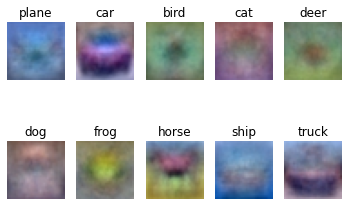

In [ ]:
# Visualize the learned weights for each class.
# Hint: reshape your weights (w/o bias) to (32, 32, 3, 10), then use min-max normalization and rescale them back to 0-255.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#print(best_svm.w.shape)
best_weights = best_softmax.w[:-1, :]
best_weights = best_weights.reshape(32,32,3,10)
best_weights_min, best_weights_max = np.min(best_weights), np.max(best_weights)

# plot for each class
for i in range(len(classes)):
  plt.subplot(2, 5, i + 1) 
  img = 255.0 * (best_weights[:, :, :, i].squeeze() - best_weights_min) / (best_weights_max - best_weights_min)
  plt.imshow(img.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])


Describe what your visualized weights look like compared to SVM weights.

Your comments: As compared to the SVM weights, softmax weights seem to appear less noisy. The template of different classes is much more clearer. For example, the horse class template looks like a two headed horse. It feels as if the templates/weights are somoothed out. 

# Section 3. Multilayer Perceptron (MLP)
In this section, we present you a modified version of simple neural network from Professor Vicente Ordonez at the University of Virginia. You job is to read through the implementation (optional, but highly recommended), and try the MLP classifier. For additional resources on understanding forward and backpropagation, you can check the materials here: http://cs231n.github.io/optimization-2/

Consider a single-layer supervised neural network that has 4 inputs and 3 outputs. First, let's review the skeleton of a single linear layer neural network. The inputs of the network are the variables $x_1, x_2, x_3, x_4$, or the input vector $\mathbf{x}=[x_1, x_2, x_3, x_4]$, the outputs of the network are $\widehat{y}_1,\widehat{y}_2,\widehat{y}_3$, or the output vector $\widehat{\mathbf{y}}=[$$\widehat{y}$$_1,\widehat{y}_2,\widehat{y}_3]$:

The given $j$-th output $\widehat{y}_j$ of this single linear layer + activation function is computed as follows:

$$\widehat{y}_j= \text{sigmoid}(w_{1j}x_1 + w_{2j}x_2 + w_{3j}x_3 + w_{4j}x_4 + b_j) = \text{sigmoid}\Big(\sum_{i=1}^{i=4}w_{ij}x_{i} + b_j\Big)$$

In matrix notation, this would be: 

\begin{equation}
\begin{bmatrix}
  \widehat{y}_{1} \\ 
  \widehat{y}_{2} \\
  \widehat{y}_{3} 
\end{bmatrix}^T=\mathbf{Sigmoid}\Bigg(
\begin{bmatrix}
  x_{1} \\
  x_{2} \\
  x_{3} \\
  x_{4}
\end{bmatrix}^T
\begin{bmatrix}
  w_{1,1} & w_{1,2} & w_{1,3}\\
  w_{2,1} & w_{3,2} & w_{2,3}\\
  w_{3,1} & w_{3,2} & w_{3,3}\\
  w_{4,1} & w_{4,2} & w_{4,3}
\end{bmatrix}
+
\begin{bmatrix}
  b_{1} \\
  b_{2} \\
  b_{3}
\end{bmatrix}^T\Bigg)
\end{equation}

or more compactly:

\begin{equation}
\widehat{\mathbf{y}}^T = \mathbf{Sigmoid}(\mathbf{x}^T \cdot \mathbf{W} + \mathbf{b}^T)
\end{equation}

The element-wise sigmoid function is: $\mathbf{Sigmoid}(\mathbf{x}) = 1 \;/\; (1 + exp(-\mathbf{x}))$, or alternatively: $\mathbf{Sigmoid}(\mathbf{x}) = exp(\mathbf{x})\;/\;(1 + exp(\mathbf{x}))$. Here the sigmoid is separated logically into an activation layer $\sigma(x)$ and a linear layer $\text{linear}(3,4)$ as illustrated in figure. 

Training these weights $\mathbf{W}$ and biases $\mathbf{b}$ requires having many training pairs $(\widehat{\mathbf{y}}^{(m)}, \mathbf{x}^{(m)})$. The inputs $\mathbf{x}$ can be the pixels of an image, indices of words, the entries in a database, and the outputs $\widehat{\mathbf{y}}$ can also be literally anything, including a number indicating a category, a set of numbers indicating the indices of words composing a sentence, an output image itself, etc.

## 3.1. Forward-propagation

Computing the outputs $\widehat{\mathbf{y}}$ from the inputs $\mathbf{x}$ in this network composed of a single linear layer, and a sigmoid layer, is called forward-propagation. Below is the code that implements these two operations:

In [ ]:
import numpy as np
import numpy.matlib

class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        
    # y = Wx + b
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def getParameters(self):
        return [self.weight, self.bias]

# Let's test the composition of the two functions (forward-propagation in the neural network).
x1 = np.array([[1, 2, 2, 3]])
y_hat1 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x1))
print('x[1] = '+ str(x1))
print('y_hat[1] = ' + str(y_hat1) + '\n')

# Let's test the composition of the two functions (forward-propagation in the neural network).
x2 = np.array([[4, 5, 2, 1]])
y_hat2 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x2))
print('x[2] = '+ str(x2))
print('y_hat[2] = ' + str(y_hat2) + '\n')

# We can also compute both at once, which could be more efficient since it requires a single matrix multiplication.
x = np.concatenate((x1, x2), axis = 0)
y_hat = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x))
print('x = ' + str(x))
print('y_hat = ' + str(y_hat))

x[1] = [[1 2 2 3]]
y_hat[1] = [[0.4990041  0.49874264 0.49872869]]

x[2] = [[4 5 2 1]]
y_hat[2] = [[0.50104419 0.49928123 0.50360515]]

x = [[1 2 2 3]
 [4 5 2 1]]
y_hat = [[0.50198893 0.49924363 0.49908869]
 [0.5023883  0.49937427 0.49882681]]


## 3.2. Loss functions.

After computing the output predictions $\widehat{\mathbf{y}}$ it is necessary to compare these against the true values of $\mathbf{y}$. Let's call these true, correct, or desired values $\mathbf{y}$. Typically, a simple loss or cost function is used to measure the degree by which the prediction $\widehat{\mathbf{y}}$ is wrong with respect to $\mathbf{y}$. A common loss function for regression is the sum of squared differences between the prediction and its true value. Assuming a prediction $\widehat{\mathbf{y}}^{(d)}$ for our training sample $\mathbf{x}^{(d)}$ with true value $\mathbf{y}^{(d)}$, then the loss can be computed as:

$$loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)}) = (\widehat{y}^{(d)}_1 - y^{(d)}_1)^2 + (\widehat{y}^{(d)}_2 - y^{(d)}_2)^2 + (\widehat{y}^{(d)}_3 - y^{(d)}_3)^2 = \sum_{j=1}^{j=3}(\widehat{y}^{(d)}_j - y^{(d)}_j)^2$$

The goal is to modify the parameters [$\mathbf{W}, \mathbf{b}$] in the Linear layer so that the value of $loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$ becomes as small as possible for all training samples in a set $D=\{(\mathbf{x}^{(d)},\mathbf{y}^{(d)})\}$. This would in turn ensure that predictions $\widehat{\mathbf{y}}$ are as similar as possible to the true values $\mathbf{y}$. To achieve this we need to minimize the following function:

$$\mathcal{L}(\mathbf{W}, \mathbf{b}) = \sum_{d=1}^{d=|D|} loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$$

The only two variables for our model in the function $\mathcal{L}(\mathbf{W}, \mathbf{b})$ are $\mathbf{W}$ and $\mathbf{b}$, this is because the training dataset $D$ is fixed. Finding the values of $\mathbf{W}$ and $\mathbf{b}$ that minimize the the loss, particularly for complex functions, is typically done using gradient based optimization, like Stochastic Gradient Descent (SGD). 

In [ ]:
class nn_MSECriterion:  # MSE = mean squared error.
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))

# Let's test the loss function.
y_hat = np.array([[0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33]])
y_true = np.array([[0.25, 0.25, 0.25], [0.33, 0.33, 0.33], [0.77, 0.77, 0.77], [0.80, 0.80, 0.80]])

nn_MSECriterion().forward(y_hat, y_true)

1.6271000000000002

## 3.3. Backward-propagation (Backpropagation)

As we discussed in class, backpropagation is just applying the chain-rule in calculus to compute the derivative of a function which is the composition of many functions (this is essentially definition of the neural network). 

Below is the implementation of required derivative computations for our simple network. You are highly advised to derive the derivatives implemented here to make sure you understand how one arrives at them. 

In [ ]:
# This is referred above as f(u).

class nn_MSECriterion:
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))
        
    def backward(self, predictions, labels):
        num_samples = labels.shape[0]
        return 2 * (predictions - labels)
    
# This is referred above as g(v).
class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, x, gradOutput):
        # It is usually a good idea to use gv from the forward pass and not recompute it again here.
        gv = 1 / (1 + np.exp(-x))
        return np.multiply(np.multiply(gv, (1 - gv)), gradOutput)

# This is referred above as h(W, b)
class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        self.gradWeight = np.zeros_like(self.weight)
        self.gradBias = np.zeros_like(self.bias)
        
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def backward(self, x, gradOutput):
        # dL/dw = dh/dw * dL/dv
        self.gradWeight = np.dot(x.T, gradOutput)
        # dL/db = dh/db * dL/dv
        #self.gradBias = np.copy(gradOutput)
        self.gradBias = np.copy(np.sum(gradOutput, axis=0))
        # return dL/dx = dh/dx * dL/dv
        return np.dot(gradOutput, self.weight.T)
    
    def getParameters(self):
        params = [self.weight, self.bias]
        gradParams = [self.gradWeight, self.gradBias]
        return params, gradParams
    
# Let's test some dummy inputs for a full pass of forward and backward propagation.
x1 = np.array([[1, 2, 2, 3]])
y1 = np.array([[0.25, 0.25, 0.25]])

# Define the operations.
linear = nn_Linear(4, 3)  # h(W, b)
sigmoid = nn_Sigmoid()  # g(v)
loss = nn_MSECriterion()  # f(u)

# Forward-propagation.
lin = linear.forward(x1)
y_hat = sigmoid.forward(lin)
loss_val = loss.forward(y_hat, y1) # Loss function.

# Backward-propagation.
dy_hat = loss.backward(y_hat, y1)
dlin = sigmoid.backward(lin, dy_hat)
dx1 = linear.backward(x1, dlin)

print('\n num_samples = ' + str(y1.shape[0]))

# Show parameters of the linear layer.
print('\nW = ' + str(linear.weight))
print('B = ' + str(linear.bias))

# Show the intermediate outputs in the forward pass.
print('\nx1    = '+ str(x1))
print('lin   = ' + str(lin))
print('y_hat = ' + str(y_hat))

print('\nloss = ' + str(loss_val))

# Show the intermediate gradients with respect to inputs in the backward pass.
print('\ndy_hat = ' + str(dy_hat))
print('dlin   = ' + str(dlin))
print('dx1    = ' + str(dx1))

# Show the gradients with respect to parameters.
print('\ndW = ' + str(linear.gradWeight))
print('dB = ' + str(linear.gradBias))


 num_samples = 1

W = [[ 0.00021114 -0.00039204  0.00107706]
 [ 0.00012821  0.00092488 -0.00068056]
 [ 0.00185527  0.00167602 -0.00106642]
 [ 0.00016323  0.00078008  0.00129365]]
B = [[-0.00077203  0.00017823 -0.00145009]]

x1    = [[1 2 2 3]]
lin   = [[3.89577041e-03 7.32822799e-03 1.39696343e-05]]
y_hat = [[0.50097394 0.50183205 0.50000349]]

loss = 0.1889090462654487

dy_hat = [[0.50194788 0.5036641  0.50000698]]
dlin   = [[0.12548649 0.12591433 0.12500175]]
dx1    = [[1.11766056e-04 4.74735421e-05 3.10541804e-04 2.80415209e-04]]

dW = [[0.12548649 0.12591433 0.12500175]
 [0.25097299 0.25182867 0.25000349]
 [0.25097299 0.25182867 0.25000349]
 [0.37645948 0.377743   0.37500524]]
dB = [[0.12548649 0.12591433 0.12500175]]


## 3.4. Gradient checking 

The gradients can also be computed with numerical approximation using the definition of derivatives. Let a single input pair $(\mathbf{x}, \mathbf{y})$ be the input, for each entry $w_{ij}$ in the weight matrix $\mathbf{W}$, the partial derivatives can be computed as follows:

$$\frac{\partial \mathcal{L}(\mathbf{W},\mathbf{b})}{\partial w_{ij}} = \frac{\mathcal{L}(\mathbf{W} + \mathbf{E}_{ij},b) - \mathcal{L}(\mathbf{W} - \mathbf{E}_{ij}, b)}{2\epsilon}, $$

where $\mathbf{E}_{ij}$ is a matrix that has $\epsilon$ in its $(i,j)$ entry and zeros everywhere else. Intuitively this gradient tells how would the value of the loss changes if we change a particular weight $w_{ij}$ by an $\epsilon$ amount. We can do the same to compute derivatives with respect to the bias parameters $b_i$. Below is the code that checks for a given input $(\mathbf{x}, \mathbf{y})$, the gradients for the matrix $\mathbf{W}$. 

In [ ]:
# We will compute derivatives with respect to a single data pair (x,y)
x = np.array([[2.34, 3.8, 34.44, 5.33]])
y = np.array([[3.2, 4.2, 5.3]])

# Define the operations.
linear = nn_Linear(4, 3)
sigmoid = nn_Sigmoid()
criterion = nn_MSECriterion()

# Forward-propagation.
a0 = linear.forward(x)
a1 = sigmoid.forward(a0)
loss = criterion.forward(a1, y) # Loss function.

# Backward-propagation.
da1 = criterion.backward(a1, y)
da0 = sigmoid.backward(a0, da1)
dx = linear.backward(x, da0)

gradWeight = linear.gradWeight
gradBias = linear.gradBias

approxGradWeight = np.zeros_like(linear.weight)
approxGradBias = np.zeros_like(linear.bias)

# We will verify here that gradWeights are correct and leave it as an excercise
# to verify the gradBias.
epsilon = 0.0001
for i in range(0, linear.weight.shape[0]):
    for j in range(0, linear.weight.shape[1]):
        # Compute f(w)
        fw = criterion.forward(sigmoid.forward(linear.forward(x)), y) # Loss function.
        # Compute f(w + eps)
        shifted_weight = np.copy(linear.weight)
        shifted_weight[i, j] = shifted_weight[i, j] + epsilon
        shifted_linear = nn_Linear(4, 3)
        shifted_linear.bias = linear.bias
        shifted_linear.weight = shifted_weight
        fw_epsilon = criterion.forward(sigmoid.forward(shifted_linear.forward(x)), y) # Loss function
        # Compute (f(w + eps) - f(w)) / eps
        approxGradWeight[i, j] = (fw_epsilon - fw) / epsilon

# These two outputs should be similar up to some precision.
print('gradWeight: ' + str(gradWeight))
print('\napproxGradWeight: ' + str(approxGradWeight))

gradWeight: [[ -3.16486828  -4.33753052  -5.62365379]
 [ -5.13952968  -7.04385299  -9.13242923]
 [-46.580369   -63.83955181 -82.76864808]
 [ -7.20886663  -9.87993064 -12.80943363]]

approxGradWeight: [[ -3.16483799  -4.33750474  -5.62362966]
 [ -5.13944978  -7.04378496  -9.13236555]
 [-46.57376498 -63.83390788 -82.76334382]
 [ -7.20870939  -9.87979674 -12.80930825]]


## Section 3.4. Playing with the Simple NN
Now, we provide a simple NN model that has an training accuracy around 46%. You job here is to first run and check the simple NN model, and the experiments it with:
- Try using 3 different numbers of layers for the simple NN, and plot the accuracy as a function of the number of layers. 
- Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried.
- Try different activation function (Sigmoid, ReLU)
- Briefly describe what you've observed in the above experiments

Note that you are free to create your own Simple_NN class for your experiments.

In [ ]:
class nn_CECriterionWithLogits:
    def forward(self, logits, labels):
        y_indices = np.arange(len(labels))
        self.probs = softmax(logits)
        correct_class_prob = self.probs[y_indices, labels].reshape(-1, 1)
        loss = np.sum(-np.log(correct_class_prob)) / len(correct_class_prob)
        return loss
    
    def backward(self, labels):
        y_indices = np.arange(len(labels))
        gradOutput = self.probs
        gradOutput[y_indices, labels] -= 1
        return gradOutput / len(labels)
    
class nn_ReLU:
    def forward(self, x):
        # Forward pass.
        return np.maximum(0, x)
    
    def backward(self, x, gradOutput):
        # Backward pass
        return np.where(x < 0, 0, np.multiply(1, gradOutput))
    
def softmax(x):
    exp = np.exp(x - x.max()) # stability trick
    return (exp / np.sum(exp, axis=1))

In [ ]:
class Simple_NN(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

As the bias is explicitly handled in the MLP code, stripped off the ones we have concatenated to the feature vectors.

In [ ]:
X_train = X_train[:, :3072]
X_val = X_val[:, :3072]
X_test = X_test[:, :3072]

Now, run the simple NN to check the accuracy:

In [ ]:
model = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=1e-4)

Iter 100/1500 - loss: 2.25854922614941 
Iter 200/1500 - loss: 2.173914622697096 
Iter 300/1500 - loss: 2.0677757083777646 
Iter 400/1500 - loss: 2.0017622163027555 
Iter 500/1500 - loss: 1.9480385796514659 
Iter 600/1500 - loss: 1.8810958800409452 
Iter 700/1500 - loss: 1.8727209182884053 
Iter 800/1500 - loss: 1.796526377523859 
Iter 900/1500 - loss: 1.7954332727292788 
Iter 1000/1500 - loss: 1.8551354286536839 
Iter 1100/1500 - loss: 1.7786410244466464 
Iter 1200/1500 - loss: 1.7630427855695947 
Iter 1300/1500 - loss: 1.7646659704927015 
Iter 1400/1500 - loss: 1.8297385239956512 
Iter 1500/1500 - loss: 1.7384880674610261 


The training accuracy is given by : 39.530612
The training accuracy is given by : 39.900000


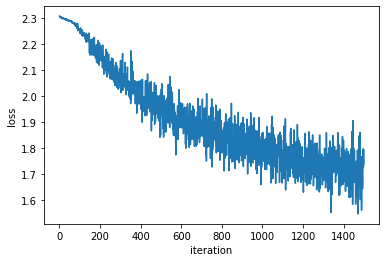

In [ ]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model.predict(X_val)
print('The training accuracy is given by : %f' % (get_acc(predict, y_val)))

### Section 3.4.1. Different numbers of layers
Try building 3 simple NN with different numbers of layers. Plot the training/validation/test accuracy as a function of the numbers of layers.

In [ ]:
results3_4_1 = {}

#### 3-Layer Network

In [ ]:
class NN_3_Layers(object):
  def __init__(self, input_size, output_size, hidden_state_size=64):
    self.linear1 = nn_Linear(input_size, hidden_state_size)
    self.activation1 = nn_ReLU()
    self.linear2 = nn_Linear(hidden_state_size, hidden_state_size)
    self.activation2 = nn_ReLU()
    self.linear3 = nn_Linear(hidden_state_size, output_size)

  def forward(self, X):
    self.X = X
    self.x1 = self.linear1.forward(self.X)
    self.a1 = self.activation1.forward(self.x1) 
    self.x2 = self.linear2.forward(self.a1)   
    self.a2 = self.activation2.forward(self.x2)
    logits = self.linear3.forward(self.a2)
    return logits

  def backward(self, gradOutput):
    dx3 = self.linear3.backward(self.a2, gradOutput)
    da2 = self.activation2.backward(self.x2, dx3)
    dx2 = self.linear2.backward(self.a1, da2)    
    da1 = self.activation1.backward(self.x1, dx2)
    self.linear1.backward(self.X, da1)    

  def update(self, lr):
    self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
    self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
    self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
    self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
    self.linear3.weight = self.linear3.weight - lr * (self.linear3.gradWeight)
    self.linear3.bias = self.linear3.bias - lr * (self.linear3.gradBias)

  def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
    loss_hist = []

    for i in range(n_iter):
      batch_indices = np.random.choice(len(X_train), batch_size)
      X_batch = X_train[batch_indices]
      y_batch = y_train[batch_indices]
            
      logits = self.forward(X_batch)
      loss = loss_criterion.forward(logits, y_batch)
      loss_grad = loss_criterion.backward(y_batch)
      self.backward(loss_grad)
      self.update(lr)

      if (i + 1) % 100 == 0:
        print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
      loss_hist.append(loss)
    return loss_hist

  def predict(self, X):
    return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [ ]:
model = NN_3_Layers(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 2500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=0.01, n_iter=n_iter)
predict_train = model.predict(X_train)
acc_train = get_acc(predict_train, y_train)
print('The training accuracy is given by : %f' % acc_train)
predict_val = model.predict(X_val)
acc_val = get_acc(predict_val, y_val)
print('The validation accuracy is given by : %f' % acc_val )
predict_test = model.predict(X_test)
acc_test = get_acc(predict_test, y_test)
print('The testing accuracy is given by : %f' % acc_test)
results3_4_1[3] = [acc_train, acc_val, acc_test]

Iter 100/2500 - loss: 2.301448869067347 
Iter 200/2500 - loss: 2.207465197208124 
Iter 300/2500 - loss: 1.9135989434886698 
Iter 400/2500 - loss: 1.7562627842273926 
Iter 500/2500 - loss: 1.6192750776283875 
Iter 600/2500 - loss: 1.725343030408572 
Iter 700/2500 - loss: 1.671611333449839 
Iter 800/2500 - loss: 1.475730346934741 
Iter 900/2500 - loss: 1.4677042371052722 
Iter 1000/2500 - loss: 1.3953171844404113 
Iter 1100/2500 - loss: 1.4509293588894985 
Iter 1200/2500 - loss: 1.4462666738822048 
Iter 1300/2500 - loss: 1.3680620060931978 
Iter 1400/2500 - loss: 1.5029206800728518 
Iter 1500/2500 - loss: 1.4251473402539403 
Iter 1600/2500 - loss: 1.3445726523334554 
Iter 1700/2500 - loss: 1.367189884619532 
Iter 1800/2500 - loss: 1.482329734656837 
Iter 1900/2500 - loss: 1.283359299859681 
Iter 2000/2500 - loss: 1.2852466753810763 
Iter 2100/2500 - loss: 1.4036255026423783 
Iter 2200/2500 - loss: 1.2908728387345962 
Iter 2300/2500 - loss: 1.3245621622997472 
Iter 2400/2500 - loss: 1.174

####4-Layer Network

In [ ]:
class NN_4_Layers(object):
  def __init__(self, input_size, output_size, hidden_state_size=64):
    self.linear1 = nn_Linear(input_size, hidden_state_size)
    self.activation1 = nn_ReLU()
    self.linear2 = nn_Linear(hidden_state_size, hidden_state_size)
    self.activation2 = nn_ReLU()
    self.linear3 = nn_Linear(hidden_state_size, hidden_state_size)
    self.activation3 = nn_ReLU()
    self.linear4 = nn_Linear(hidden_state_size, output_size)

  def forward(self, X):
    self.X = X
    self.x1 = self.linear1.forward(self.X)
    self.a1 = self.activation1.forward(self.x1) 
    self.x2 = self.linear2.forward(self.a1)   
    self.a2 = self.activation2.forward(self.x2)
    self.x3 = self.linear3.forward(self.a2) 
    self.a3 = self.activation3.forward(self.x3)
    logits = self.linear4.forward(self.a3)
    return logits  

  def backward(self, gradOutput):
    dx4 = self.linear4.backward(self.a3, gradOutput)
    da3 = self.activation3.backward(self.x3, dx4)
    dx3 = self.linear3.backward(self.a2, da3)
    da2 = self.activation2.backward(self.x2, dx3)
    dx2 = self.linear2.backward(self.a1, da2)
    da1 = self.activation1.backward(self.x1, dx2)
    self.linear1.backward(self.X, da1)
        

  def update(self, lr):
    self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
    self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
    self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
    self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
    self.linear3.weight = self.linear3.weight - lr * (self.linear3.gradWeight)
    self.linear3.bias = self.linear3.bias - lr * (self.linear3.gradBias)
    self.linear4.weight = self.linear4.weight - lr * (self.linear4.gradWeight)
    self.linear4.bias = self.linear4.bias - lr * (self.linear4.gradBias)

  def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
    loss_hist = []

    for i in range(n_iter):
      batch_indices = np.random.choice(len(X_train), batch_size)
      X_batch = X_train[batch_indices]
      y_batch = y_train[batch_indices]
            
      logits = self.forward(X_batch)
      loss = loss_criterion.forward(logits, y_batch)
      loss_grad = loss_criterion.backward(y_batch)
      self.backward(loss_grad)
      self.update(lr)

      if (i + 1) % 100 == 0:
        print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
      loss_hist.append(loss)
    return loss_hist

  def predict(self, X):
    return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [ ]:
model = NN_4_Layers(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 2500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=0.1, n_iter=n_iter)
predict_train = model.predict(X_train)
acc_train = get_acc(predict_train, y_train)
print('The training accuracy is given by : %f' % acc_train)
predict_val = model.predict(X_val)
acc_val = get_acc(predict_val, y_val)
print('The validation accuracy is given by : %f' % acc_val )
predict_test = model.predict(X_test)
acc_test = get_acc(predict_test, y_test)
print('The testing accuracy is given by : %f' % acc_test)
results3_4_1[4] = [acc_train, acc_val, acc_test]

Iter 100/2500 - loss: 2.303073436784948 
Iter 200/2500 - loss: 2.302134750869818 
Iter 300/2500 - loss: 2.3027356419953633 
Iter 400/2500 - loss: 2.3028878770825223 
Iter 500/2500 - loss: 2.3028421965483266 
Iter 600/2500 - loss: 2.3029858572989768 
Iter 700/2500 - loss: 2.3020832032629044 
Iter 800/2500 - loss: 2.3031947990485113 
Iter 900/2500 - loss: 2.302092899162142 
Iter 1000/2500 - loss: 2.304314405759524 
Iter 1100/2500 - loss: 2.302863757345085 
Iter 1200/2500 - loss: 2.30329878994692 
Iter 1300/2500 - loss: 2.3031299370515446 
Iter 1400/2500 - loss: 2.3055426986373413 
Iter 1500/2500 - loss: 2.11968518022119 
Iter 1600/2500 - loss: 2.0739352836199023 
Iter 1700/2500 - loss: 2.0114045028221907 
Iter 1800/2500 - loss: 1.9602369251695688 
Iter 1900/2500 - loss: 2.0303950014129395 
Iter 2000/2500 - loss: 1.7959112155416221 
Iter 2100/2500 - loss: 1.9215354657640185 
Iter 2200/2500 - loss: 1.9295490344986945 
Iter 2300/2500 - loss: 1.7178432102621917 
Iter 2400/2500 - loss: 1.8636

####5-layer Neural Network

In [ ]:
class NN_5_Layers(object):
  def __init__(self, input_size, output_size, hidden_state_size=64):

    self.linear1 = nn_Linear(input_size, hidden_state_size)
    self.activation1 = nn_ReLU()
    self.linear2 = nn_Linear(hidden_state_size, hidden_state_size)
    self.activation2 = nn_ReLU()
    self.linear3 = nn_Linear(hidden_state_size, hidden_state_size)
    self.activation3 = nn_ReLU()
    self.linear4 = nn_Linear(hidden_state_size, hidden_state_size)
    self.activation4 = nn_ReLU()
    self.linear5 = nn_Linear(hidden_state_size, output_size)    

  def forward(self, X):
    self.X = X
    self.x1 = self.linear1.forward(self.X)
    self.a1 = self.activation1.forward(self.x1) 
    self.x2 = self.linear2.forward(self.a1)   
    self.a2 = self.activation2.forward(self.x2)
    self.x3 = self.linear3.forward(self.a2)
    self.a3 = self.activation3.forward(self.x3)
    self.x4 = self.linear4.forward(self.a3)
    self.a4 = self.activation4.forward(self.x4)
    logits = self.linear5.forward(self.a4)
    return logits

  def backward(self, gradOutput):
    dx5 = self.linear5.backward(self.a4, gradOutput)
    da4 = self.activation4.backward(self.x4, dx5)
    dx4 = self.linear4.backward(self.a3, da4)
    da3 = self.activation1.backward(self.x3, dx4)
    dx3 = self.linear3.backward(self.a2, da3)
    da2 = self.activation1.backward(self.x2, dx3)
    dx2 = self.linear2.backward(self.a1, da2)    
    da1 = self.activation1.backward(self.x1, dx2)
    self.linear1.backward(self.X, da1)    

  def update(self, lr):
    self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
    self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
    self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
    self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
    self.linear3.weight = self.linear3.weight - lr * (self.linear3.gradWeight)
    self.linear3.bias = self.linear3.bias - lr * (self.linear3.gradBias)
    self.linear4.weight = self.linear4.weight - lr * (self.linear4.gradWeight)
    self.linear4.bias = self.linear4.bias - lr * (self.linear4.gradBias)
    self.linear5.weight = self.linear5.weight - lr * (self.linear5.gradWeight)
    self.linear5.bias = self.linear5.bias - lr * (self.linear5.gradBias)

  def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
    loss_hist = []

    for i in range(n_iter):
      batch_indices = np.random.choice(len(X_train), batch_size)
      X_batch = X_train[batch_indices]
      y_batch = y_train[batch_indices]
            
      logits = self.forward(X_batch)
      loss = loss_criterion.forward(logits, y_batch)
      loss_grad = loss_criterion.backward(y_batch)
      self.backward(loss_grad)
      self.update(lr)

      if (i + 1) % 100 == 0:
        print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
      loss_hist.append(loss)
    return loss_hist

  def predict(self, X):
    return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [ ]:
model = NN_5_Layers(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 2500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=0.1, n_iter=n_iter)
predict_train = model.predict(X_train)
acc_train = get_acc(predict_train, y_train)
print('The training accuracy is given by : %f' % acc_train)
predict_val = model.predict(X_val)
acc_val = get_acc(predict_val, y_val)
print('The validation accuracy is given by : %f' % acc_val )
predict_test = model.predict(X_test)
acc_test = get_acc(predict_test, y_test)
print('The testing accuracy is given by : %f' % acc_test)
results3_4_1[5] = [acc_train, acc_val, acc_test]

Iter 100/2500 - loss: 2.3020728099907517 
Iter 200/2500 - loss: 2.301461651772167 
Iter 300/2500 - loss: 2.3004687887987747 
Iter 400/2500 - loss: 2.303768888606963 
Iter 500/2500 - loss: 2.30229397597631 
Iter 600/2500 - loss: 2.3042441926786483 
Iter 700/2500 - loss: 2.3016045909552827 
Iter 800/2500 - loss: 2.304515918590226 
Iter 900/2500 - loss: 2.3016603870448566 
Iter 1000/2500 - loss: 2.3026432676543633 
Iter 1100/2500 - loss: 2.3035387306666637 
Iter 1200/2500 - loss: 2.3034362230818908 
Iter 1300/2500 - loss: 2.302122111318914 
Iter 1400/2500 - loss: 2.301599402625671 
Iter 1500/2500 - loss: 2.3030031162634437 
Iter 1600/2500 - loss: 2.302811393494258 
Iter 1700/2500 - loss: 2.3012800003976572 
Iter 1800/2500 - loss: 2.301498166987376 
Iter 1900/2500 - loss: 2.303205656742731 
Iter 2000/2500 - loss: 2.302961635674897 
Iter 2100/2500 - loss: 2.3016992967271768 
Iter 2200/2500 - loss: 2.3038355909030566 
Iter 2300/2500 - loss: 2.3030100561640467 
Iter 2400/2500 - loss: 2.301248

In [ ]:
print(results3_4_1)
layers = list(dict.keys(results3_4_1))
accuracies = list(dict.values(results3_4_1))
train_accuracy = []
val_accuracy = []
test_accuracy = []

for values in accuracies:
  train_accuracy.append(values[0])
  val_accuracy.append(values[1])
  test_accuracy.append(values[2])

{3: [55.5265306122449, 49.0, 48.5], 4: [35.50408163265306, 36.199999999999996, 36.1], 5: [10.044897959183674, 7.8, 9.0]}


Text(0.5, 0, 'Number of Layers')

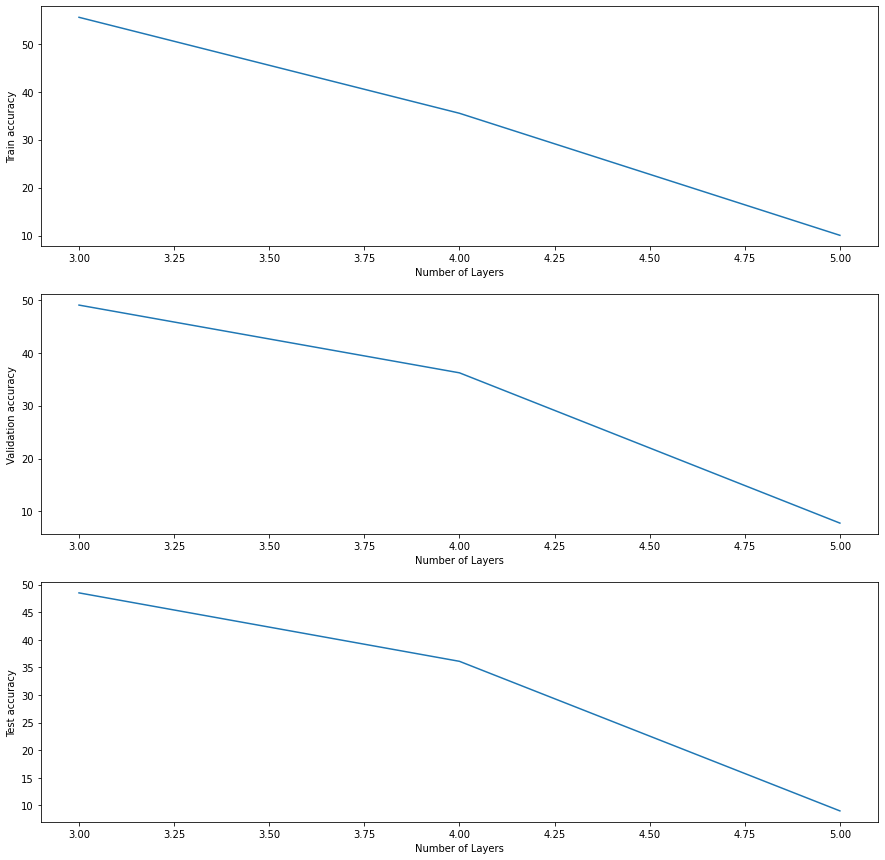

In [ ]:
# plotting
fig, axs = plt.subplots(3, figsize=(15,15))
axs[0].plot(layers, train_accuracy)
axs[0].set_ylabel("Train accuracy")
axs[0].set_xlabel("Number of Layers")
axs[1].plot(layers, val_accuracy)
axs[1].set_ylabel("Validation accuracy")
axs[1].set_xlabel("Number of Layers")
axs[2].plot(layers, test_accuracy)
axs[2].set_ylabel("Test accuracy")
axs[2].set_xlabel("Number of Layers")

### Section 3.4.2. Different numbers of hidden state size
Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried. We recommend you to test numbers like 8, 16, 32, 64, 128, 256. Plot the training/validation/test accuracy as a function of the hidden state size your picked.

In [ ]:
hidden_state_list = [8, 16, 32, 64, 128, 256]
batch_size = 200
results = {}
for hidden_state in hidden_state_list:
  print(f"Number of hidden states:{hidden_state}")
  model = NN_3_Layers(X_train.shape[1], np.max(y_train)+1, hidden_state_size=hidden_state)  
  loss_hist = model.train(X_train, y_train, lr=0.01)  
  predict_train = model.predict(X_train)
  acc_train = get_acc(predict_train, y_train)
  print('The training accuracy is given by : %f' % acc_train)
  predict_val = model.predict(X_val)
  acc_val = get_acc(predict_val, y_val)
  print('The validation accuracy is given by : %f' % acc_val )
  predict_test = model.predict(X_test)
  acc_test = get_acc(predict_test, y_test)
  print('The testing accuracy is given by : %f' % acc_test)
  results[hidden_state] = [acc_train, acc_val, acc_test]  
  print("done\n")

Number of hidden states:8
Iter 100/1500 - loss: 2.3024861891747905 
Iter 200/1500 - loss: 2.3029601895759835 
Iter 300/1500 - loss: 2.302506403732188 
Iter 400/1500 - loss: 2.2980114032297365 
Iter 500/1500 - loss: 2.1826936654629994 
Iter 600/1500 - loss: 2.1605515195589415 
Iter 700/1500 - loss: 2.0041882644376456 
Iter 800/1500 - loss: 1.8452877300127097 
Iter 900/1500 - loss: 1.762918359039892 
Iter 1000/1500 - loss: 1.7548857038524013 
Iter 1100/1500 - loss: 1.852095907938562 
Iter 1200/1500 - loss: 1.8356796264266526 
Iter 1300/1500 - loss: 1.6693727311651188 
Iter 1400/1500 - loss: 1.7708550882556153 
Iter 1500/1500 - loss: 1.8234291175168542 
The training accuracy is given by : 37.536735
The validation accuracy is given by : 38.600000
The testing accuracy is given by : 35.800000
done

Number of hidden states:16
Iter 100/1500 - loss: 2.302766794101552 
Iter 200/1500 - loss: 2.302078113023466 
Iter 300/1500 - loss: 2.302325768381711 
Iter 400/1500 - loss: 2.11441299031372 
Iter 5

In [ ]:
print(results)
hidden_states = list(dict.keys(results))
accuracies = list(dict.values(results))
train_accuracy = []
val_accuracy = []
test_accuracy = []

for values in accuracies:
  train_accuracy.append(values[0])
  val_accuracy.append(values[1])
  test_accuracy.append(values[2])

{8: [37.53673469387755, 38.6, 35.8], 16: [44.4, 43.3, 42.8], 32: [46.62857142857143, 46.1, 46.7], 64: [52.465306122448986, 49.3, 48.4], 128: [53.72857142857143, 49.7, 51.1], 256: [55.22653061224489, 49.6, 51.2]}


Text(0.5, 0, 'Hidden states')

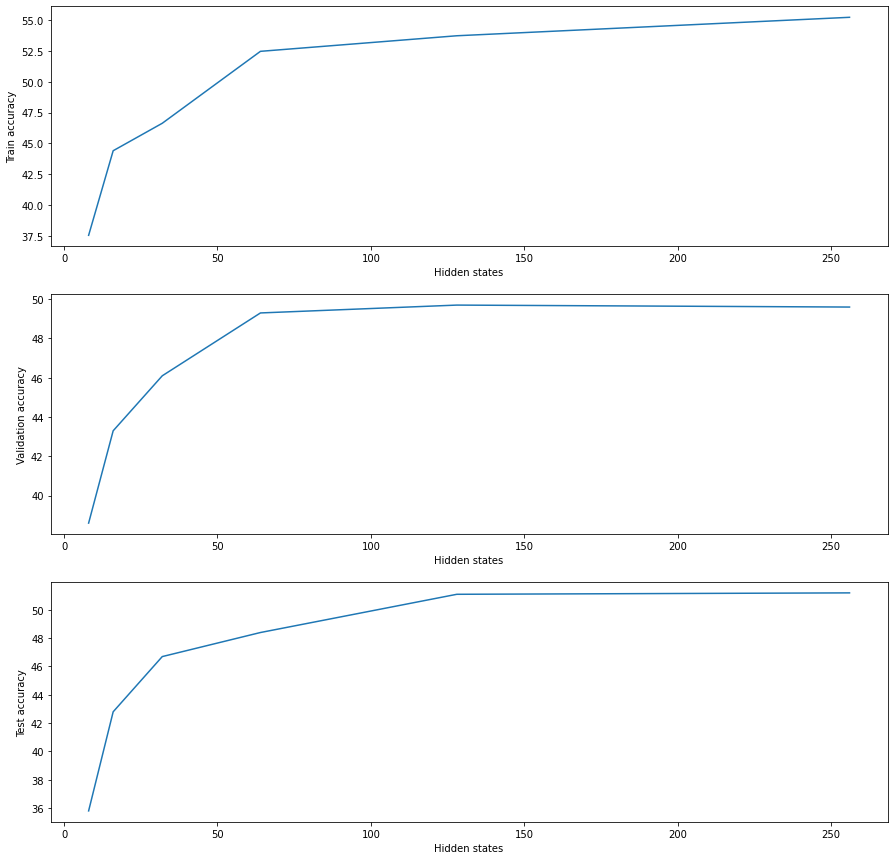

In [ ]:
# plotting
fig, axs = plt.subplots(3, figsize=(15,15))
axs[0].plot( hidden_states, train_accuracy)
axs[0].set_ylabel("Train accuracy")
axs[0].set_xlabel("Hidden states")
axs[1].plot(hidden_states, val_accuracy)
axs[1].set_ylabel("Validation accuracy")
axs[1].set_xlabel("Hidden states")
axs[2].plot(hidden_states, test_accuracy)
axs[2].set_ylabel("Test accuracy")
axs[2].set_xlabel("Hidden states")

### Section 3.4.3. Different activation functions
Try both ReLU and Sigmoid activation, and report the training/validation/test accuracy.

###Sigmoid Activation Function

In [ ]:
class Simple_NN_Sigmoid(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_Sigmoid()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.bias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [ ]:
model = Simple_NN_Sigmoid(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=1e-4, n_iter=n_iter)

Iter 100/1500 - loss: 2.3009672711189797 
Iter 200/1500 - loss: 2.2999384615448077 
Iter 300/1500 - loss: 2.2994635654178714 
Iter 400/1500 - loss: 2.297071550253447 
Iter 500/1500 - loss: 2.296290751278079 
Iter 600/1500 - loss: 2.2934320988573784 
Iter 700/1500 - loss: 2.2919469508251584 
Iter 800/1500 - loss: 2.2905431887240657 
Iter 900/1500 - loss: 2.289289046011104 
Iter 1000/1500 - loss: 2.288062182881736 
Iter 1100/1500 - loss: 2.282760457575448 
Iter 1200/1500 - loss: 2.278182744192502 
Iter 1300/1500 - loss: 2.2782418893345846 
Iter 1400/1500 - loss: 2.275475983602583 
Iter 1500/1500 - loss: 2.2724060363477845 


The training accuracy is given by : 24.520408
The training accuracy is given by : 24.800000
The training accuracy is given by : 26.400000


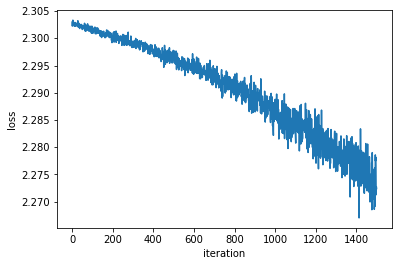

In [ ]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model.predict(X_val)
print('The training accuracy is given by : %f' % (get_acc(predict, y_val)))
predict = model.predict(X_test)
print('The training accuracy is given by : %f' % (get_acc(predict, y_test)))

###Relu Activation Function

In [ ]:
class Simple_NN_Relu(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.bias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

In [ ]:
model = Simple_NN_Relu(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=1e-4, n_iter=n_iter)

Iter 100/1500 - loss: 2.2411398177588118 
Iter 200/1500 - loss: 2.152462983277216 
Iter 300/1500 - loss: 2.0308412723395834 
Iter 400/1500 - loss: 2.020600732906421 
Iter 500/1500 - loss: 1.9392806782551049 
Iter 600/1500 - loss: 1.8862482513863281 
Iter 700/1500 - loss: 1.8767068466504495 
Iter 800/1500 - loss: 1.8720219314278672 
Iter 900/1500 - loss: 1.7684142213742893 
Iter 1000/1500 - loss: 1.7422125908908594 
Iter 1100/1500 - loss: 1.752230403239808 
Iter 1200/1500 - loss: 1.731796479566729 
Iter 1300/1500 - loss: 1.68528822947815 
Iter 1400/1500 - loss: 1.6378460144754126 
Iter 1500/1500 - loss: 1.6469603690956993 


The training accuracy is given by : 40.253061
The training accuracy is given by : 40.500000
The training accuracy is given by : 39.500000


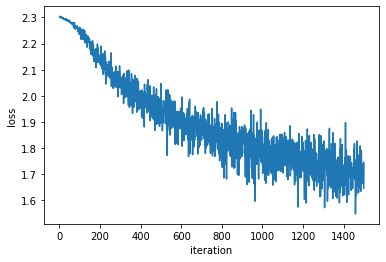

In [ ]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model.predict(X_val)
print('The training accuracy is given by : %f' % (get_acc(predict, y_val)))
predict = model.predict(X_test)
print('The training accuracy is given by : %f' % (get_acc(predict, y_test)))
